In [35]:
import dimod
from dwave.system import LeapHybridCQMSampler
from itertools import combinations
from dimod import Binary
def solve_vertex_cover(graph):
    
    cqm = dimod.ConstrainedQuadraticModel()

    vertices = set(v for edge in graph for v in edge)
    vertex_used = [Binary(f'vertex_used_{j}') for j in vertices]

    objective = sum(vertex_used[v] for v in vertices)
    cqm.set_objective(objective)

    for u, v in graph:
        cqm.add_constraint(vertex_used[u] + vertex_used[v] >= 1, label=f'edge_{u}_{v}')

    sampler = LeapHybridCQMSampler()
    solution = sampler.sample_cqm(cqm, label='test_petersen_graph')

    feasible_solutions = solution.filter(lambda sample: sample.is_feasible)
    if len(feasible_solutions):
        best_solution = feasible_solutions.first.sample
        min_vertex_cover = [v for v in vertices if best_solution[f'vertex_used_{v}'] == 1]
        return min_vertex_cover, solution

graph = list(combinations(range(0,4), 2))
min_vertex_cover, solution = solve_vertex_cover(graph)
print("Minimum Vertex Cover:", min_vertex_cover)

Minimum Vertex Cover: [0, 1, 3]


In [1]:
import networkx as nx

In [2]:
G = nx.petersen_graph()

In [3]:
print(G.edges)

[(0, 1), (0, 4), (0, 5), (1, 2), (1, 6), (2, 3), (2, 7), (3, 4), (3, 8), (4, 9), (5, 7), (5, 8), (6, 8), (6, 9), (7, 9)]


In [36]:
min_vertex_cover, solution = solve_vertex_cover(G.edges)
print("Minimum Vertex Cover:", min_vertex_cover)

Minimum Vertex Cover: [1, 3, 4, 5, 6, 7]


In [56]:
import pandas as pd

df = solution.aggregate().to_pandas_dataframe(sample_column=True) 
print(df)

                                               sample  energy  \
0   {'vertex_used_0': 0.0, 'vertex_used_1': 1.0, '...     6.0   
1   {'vertex_used_0': 1.0, 'vertex_used_1': 0.0, '...     6.0   
2   {'vertex_used_0': 1.0, 'vertex_used_1': 1.0, '...     6.0   
3   {'vertex_used_0': 1.0, 'vertex_used_1': 0.0, '...     6.0   
4   {'vertex_used_0': 0.0, 'vertex_used_1': 1.0, '...     6.0   
5   {'vertex_used_0': 0.0, 'vertex_used_1': 1.0, '...     6.0   
6   {'vertex_used_0': 1.0, 'vertex_used_1': 0.0, '...     7.0   
7   {'vertex_used_0': 0.0, 'vertex_used_1': 1.0, '...     7.0   
8   {'vertex_used_0': 0.0, 'vertex_used_1': 1.0, '...     4.0   
9   {'vertex_used_0': 0.0, 'vertex_used_1': 1.0, '...     4.0   
10  {'vertex_used_0': 1.0, 'vertex_used_1': 0.0, '...     4.0   
11  {'vertex_used_0': 1.0, 'vertex_used_1': 0.0, '...     4.0   
12  {'vertex_used_0': 1.0, 'vertex_used_1': 0.0, '...     4.0   
13  {'vertex_used_0': 0.0, 'vertex_used_1': 1.0, '...     4.0   
14  {'vertex_used_0': 0.0

AttributeError: Line2D.set() got an unexpected keyword argument 'type'

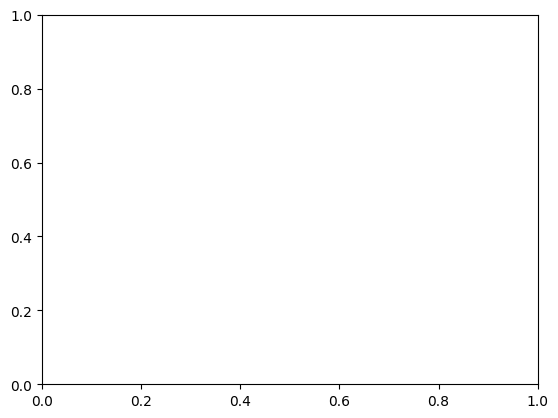

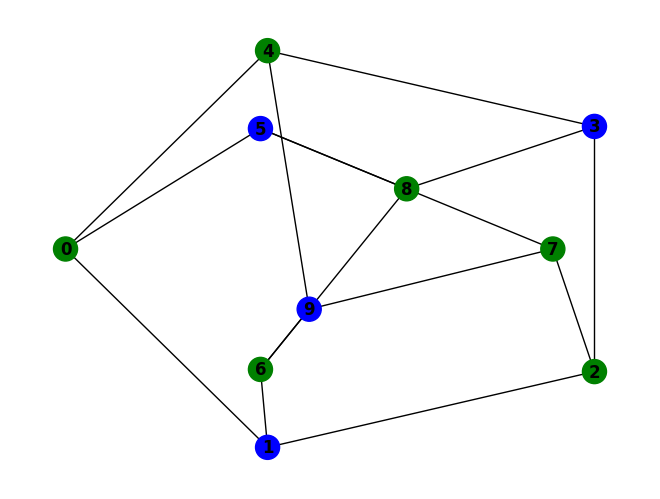

In [6]:
import matplotlib.pyplot as plt

color_map = list(range(0,10))
for node in G:
    if node in min_vertex_cover:
        color_map[node]='green'
    else: 
        color_map[node]= 'blue'      
nx.draw_shell(G, node_color=color_map, nlist=[range(8, 10), range(5,8), range(5)], with_labels=True, font_weight='bold')
# nx.draw_shell(G, node_color=color_map, with_labels=True)
plt.show()

__USING QUBO__

In [76]:
from dwave.system import DWaveSampler, EmbeddingComposite
from dimod import quicksum

def solve_vertex_cover_qubo(graph):
    
    vertices = list(set(v for edge in graph for v in edge))
    vertex_used = [Binary(f'vertex_used_{j}') for j in vertices]

    # Q = {(node, node): 2 for node in G}
    # Q.update({edge: 100 for edge in G.edges})

    linear = {(vertices[i], vertices[i]): -5 for i,j in enumerate(vertices)}
    # linear = {{(vertices[i], vertices[i]): -2, (vertices[j], vertices[j]): -2} for i,j in enumerate(graph)}
    quadratic = {(j[0], j[1]): 2 for i,j in enumerate(graph)}

    Q = {**linear, **quadratic}

    # Q = quicksum((vertex_used[u])*(vertex_used[v]) for u,v in graph) + 2*quicksum(vertex_used[i] for i in vertices)
    # print(quicksum((1-vertex_used[u])*(1-vertex_used[v]) for u,v in graph))
    sampler = EmbeddingComposite(DWaveSampler())
    
    solution = sampler.sample_qubo(Q, num_reads=5000, label='test_petersen_graph_qubo')
    print(solution)
    return solution
    # feasible_solutions = solution.filter(lambda sample: sample.is_feasible)
    # if len(feasible_solutions):
    #     best_solution = feasible_solutions.first.sample
    #     min_vertex_cover = [v for v in vertices if best_solution[f'vertex_used_{v}'] == 1]
    #     return min_vertex_cover

In [77]:
min_vertex_cover_qubo = solve_vertex_cover_qubo(G.edges)
# print("Minimum Vertex Cover using qubo:", min_vertex_cover_qubo)

    0  1  2  3  4  5  6  7  8  9 energy num_oc. chain_.
0   0  1  0  1  1  1  1  1  0  0  -24.0     882     0.0
1   1  1  0  1  0  0  0  1  1  1  -24.0    1226     0.0
2   1  0  1  0  1  0  1  1  1  0  -24.0     959     0.0
3   0  1  1  0  1  1  0  0  1  1  -24.0     733     0.0
4   1  0  1  1  0  1  1  0  0  1  -24.0    1189     0.0
5   0  1  1  1  1  1  1  0  0  1  -23.0       1     0.0
6   0  1  1  1  1  1  1  1  0  0  -23.0       1     0.0
7   1  1  0  1  0  0  1  1  1  1  -23.0       1     0.0
8   0  1  0  1  1  1  1  1  0  1  -23.0       1     0.0
9   1  1  1  1  0  0  0  1  1  1  -23.0       1     0.0
10  1  1  0  1  1  0  1  1  1  0  -23.0       2     0.0
11  1  1  0  1  1  1  1  1  0  0  -23.0       1     0.0
12  1  0  1  1  0  1  1  1  0  1  -23.0       1     0.0
13  1  1  0  1  0  1  0  1  1  1  -23.0       2     0.0
['BINARY', 14 rows, 5000 samples, 10 variables]


__USING CQM to BQM function__

In [20]:
import dimod
from dwave.system import LeapHybridCQMSampler
from itertools import combinations
from dimod import Binary, cqm_to_bqm
def solve_vertex_cover_cqm_to_bqm(graph):
    
    cqm = dimod.ConstrainedQuadraticModel()

    vertices = set(v for edge in graph for v in edge)
    vertex_used = [Binary(f'vertex_used_{j}') for j in vertices]

    objective = sum(vertex_used[v] for v in vertices)
    cqm.set_objective(objective)

    for u, v in graph:
        cqm.add_constraint(vertex_used[u] + vertex_used[v] >= 1, label=f'edge_{u}_{v}')

    bqm, invert = dimod.cqm_to_bqm(cqm,lagrange_multiplier=10)
    sampleset = dimod.ExactSolver().sample(bqm)

    print(sampleset)
    return(sampleset)

    # feasible_solutions = solution.filter(lambda sample: sample.is_feasible)
    # if len(feasible_solutions):
    #     best_solution = feasible_solutions.first.sample
    #     min_vertex_cover = [v for v in vertices if best_solution[f'vertex_used_{v}'] == 1]
    #     return min_vertex_cover

In [21]:
min_vertex_cover_cqm_to_bqm = solve_vertex_cover_cqm_to_bqm(G.edges)

KeyboardInterrupt: 

In [11]:
num_widget_a = dimod.Integer('num_widget_a', upper_bound=7)
num_widget_b = dimod.Integer('num_widget_b', upper_bound=3)
cqm = dimod.ConstrainedQuadraticModel()
cqm.set_objective(-3 * num_widget_a - 4 * num_widget_b)
cqm.add_constraint(num_widget_a + num_widget_b <= 5, label='total widgets')

'total widgets'

In [12]:
bqm, invert = dimod.cqm_to_bqm(cqm)
sampleset = dimod.ExactSolver().sample(bqm)

In [13]:
invert(sampleset.first.sample)

{'num_widget_a': 2, 'num_widget_b': 3}

In [24]:
import dwave_networkx as dnx
from dwave.system import DWaveSampler, EmbeddingComposite
sampler = EmbeddingComposite(DWaveSampler())
print(dnx.min_vertex_cover(G, sampler,num_reads=5000))

[0, 1, 3, 7, 8, 9]
